##### You can use wget to download audio data using the following command:
##### wget -A .bz2 -m -p -E -k -K -np http://festvox.org/cmu_arctic/packed/
##### After downloading all the files type the following UNIX command
##### find . -name '*.tar.bz2' -execdir tar -vxjf '{}' \;

##### Use the following command to install dependencies
##### pip install pysptk pyworld librosa tqdm nnmnkwii

######  (You must have PyTorch installed)


In [1]:
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~/"), "CCPP", "data", "voice-data", "festvox.org", "cmu_arctic", "packed")
!ls $DATA_ROOT

cmu_us_aew_arctic	   cmu_us_clb_arctic	      cmu_us_ljm_arctic
cmu_us_aew_arctic.tar.bz2  cmu_us_clb_arctic.tar.bz2  cmu_us_ljm_arctic.tar.bz2
cmu_us_ahw_arctic	   cmu_us_eey_arctic	      cmu_us_lnh_arctic
cmu_us_ahw_arctic.tar.bz2  cmu_us_eey_arctic.tar.bz2  cmu_us_lnh_arctic.tar.bz2
cmu_us_aup_arctic	   cmu_us_fem_arctic	      cmu_us_rms_arctic
cmu_us_aup_arctic.tar.bz2  cmu_us_fem_arctic.tar.bz2  cmu_us_rms_arctic.tar.bz2
cmu_us_awb_arctic	   cmu_us_gka_arctic	      cmu_us_rxr_arctic
cmu_us_awb_arctic.tar.bz2  cmu_us_gka_arctic.tar.bz2  cmu_us_rxr_arctic.tar.bz2
cmu_us_axb_arctic	   cmu_us_jmk_arctic	      cmu_us_slp_arctic
cmu_us_axb_arctic.tar.bz2  cmu_us_jmk_arctic.tar.bz2  cmu_us_slp_arctic.tar.bz2
cmu_us_bdl_arctic	   cmu_us_ksp_arctic	      cmu_us_slt_arctic
cmu_us_bdl_arctic.tar.bz2  cmu_us_ksp_arctic.tar.bz2  cmu_us_slt_arctic.tar.bz2


In [2]:


%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio



Populating the interactive namespace from numpy and matplotlib


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
print(fftlen, alpha, hop_length)
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

1024 0.41000000000000003 80


In [4]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [5]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)


In [6]:
X = PaddedFileSourceDataset(clb_source, 1200).asarray()
Y = PaddedFileSourceDataset(slt_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(97, 1200, 25)
(97, 1200, 25)


In [7]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

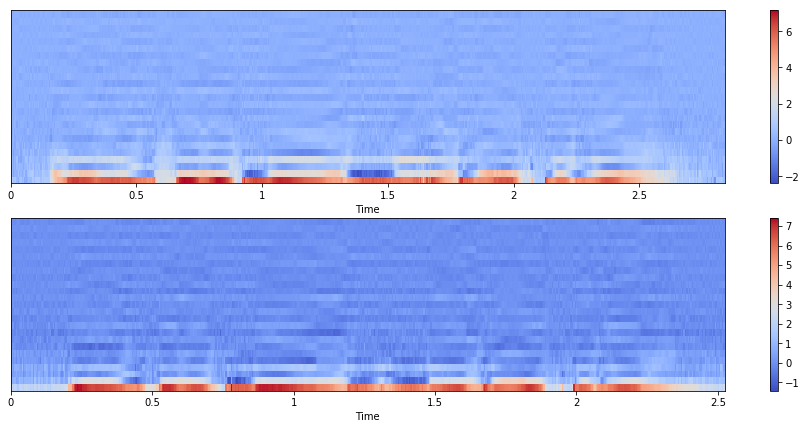

In [8]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

In [9]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

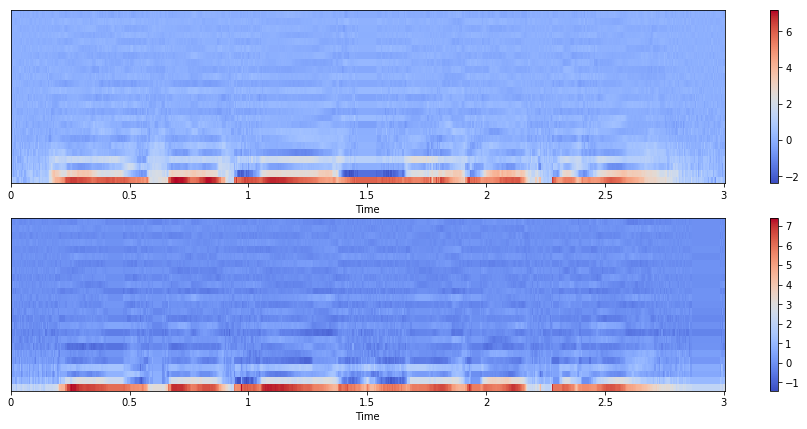

In [10]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [11]:
# Drop 1st (power) dimention
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [12]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

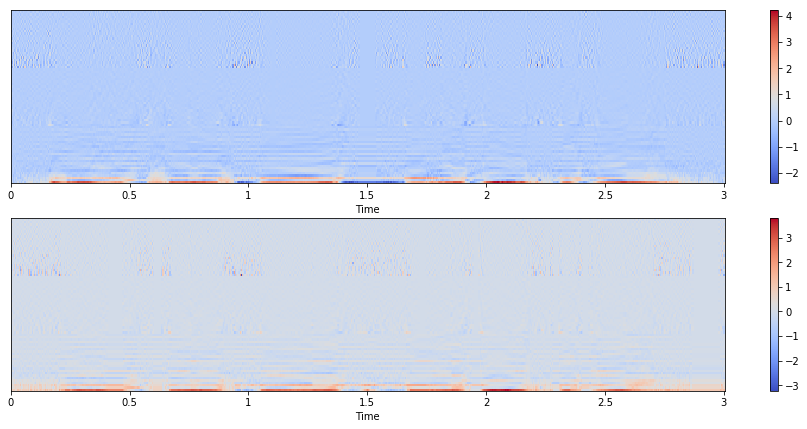

In [13]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [14]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(116400, 144)


In [15]:
XY = remove_zeros_frames(XY)
print(XY.shape)


(68186, 144)


In [ ]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40


In [ ]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

In [ ]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

In [ ]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [ ]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform


In [ ]:

for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))



In [ ]:
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

In [ ]:
idx = 0
which_dims = np.arange(0, static_dim, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)